<a href="https://colab.research.google.com/github/Rythmithik/Style-transfert/blob/main/Style_transfert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural style Transfert

In [1]:
# @title Import and define utils functions  { display-mode: "form" }
import imageio
import glob
from tqdm import tqdm
import time


!pip install -q git+https://github.com/tensorflow/docs 

import os
import tensorflow as tf
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

import IPython.display as display
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

from matplotlib import gridspec
import matplotlib.pylab as plt
import tensorflow_hub as hub


def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

def crop_center(image):
  """Returns a cropped square image."""
  shape = image.shape
  new_shape = min(shape[1], shape[2])
  offset_y = max(shape[1] - shape[2], 0) // 2
  offset_x = max(shape[2] - shape[1], 0) // 2
  image = tf.image.crop_to_bounding_box(
      image, offset_y, offset_x, new_shape, new_shape)
  return image


@functools.lru_cache(maxsize=None)
def load_image(image_url,image_name, image_size=(256, 256), preserve_aspect_ratio=True):
  """Loads and preprocesses images."""
  # Cache image file locally.
  print(os.path.basename(image_url))
  image_path = tf.keras.utils.get_file(os.path.basename(image_url), image_url)
  # Load and convert to float32 numpy array, add batch dimension, and normalize to range [0, 1].
  img = plt.imread(image_path)[:,:,:3].astype(np.float32)[np.newaxis, ...]
  print(img.shape)
  if img.max() > 1.0:
    img = img / 255.  
  if len(img.shape) == 3:
    img = tf.stack([img, img, img], axis=-1)
  img = crop_center(img)
  img = tf.image.resize(img, image_size, preserve_aspect_ratio=True)
  return img


def show_n(images, titles=('',)):
  n = len(images)
  image_sizes = [image.shape[1] for image in images]
  w = (image_sizes[0] * 6) // 320
  plt.figure(figsize=(w  * n, w))
  gs = gridspec.GridSpec(1, n, width_ratios=image_sizes)
  for i in range(n):
    plt.subplot(gs[i])
    plt.imshow(images[i][0], aspect='equal')
    plt.axis('off')
    plt.title(titles[i] if len(titles) > i else '')
  fig = plt.gcf()
  fig.savefig('all_images_generated_fast.png')
  plt.show()
  try:
    from google.colab import files
  except ImportError:
    pass
  else:
    files.download('all_images_generated_fast.png')

kim2.jpg
(1, 1067, 1600, 3)
terada3.jpeg
(1, 656, 493, 3)


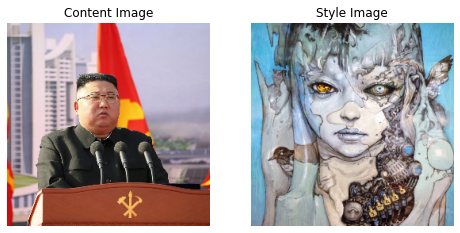

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [2]:
# @title Load example images  { display-mode: "form" ,  run: "auto" }

github_image_folder_url = "https://raw.githubusercontent.com/Rythmithik/Style-transfert/main/dataset/"  # @param {type:"string"}

content_image_name= 'kim2.jpg'  #@param ["terada3.jpeg", "terada4.jpg", "VG1.png", "VG2.jpg", "VG4.jpg", "VG5.jpg", "db1.jpg", "db2.jpg", "db3.jpg", "kim1.jpg", "kim2.jpg"]
style_image_name = 'terada3.jpeg'  #@param ["terada3.jpeg", "terada4.jpg", "VG1.png", "VG2.jpg", "VG4.jpg", "VG5.jpg", "db1.jpg", "db2.jpg", "db3.jpg", "kim1.jpg", "kim2.jpg"]
output_image_size = 256  # @param {type:"integer"}

# The content image size can be arbitrary.
content_img_size = (output_image_size, output_image_size)
# The style prediction model was trained with image size 25<<<6 and it's the 
# recommended image size for the style image (though, other sizes work as 
# well but will lead to different results).
style_img_size = (output_image_size, output_image_size)  # Recommended to keep it at 256.

content_image_url = os.path.join(github_image_folder_url, content_image_name)
style_image_url = os.path.join(github_image_folder_url, style_image_name)

content_image = load_image(content_image_url, content_img_size)
style_image = load_image(style_image_url, style_img_size)
#style_image = tf.nn.avg_pool(style_image, ksize=[3,3], strides=[1,1], padding='SAME')
show_n([content_image, style_image], ['Content Image', 'Style Image'])

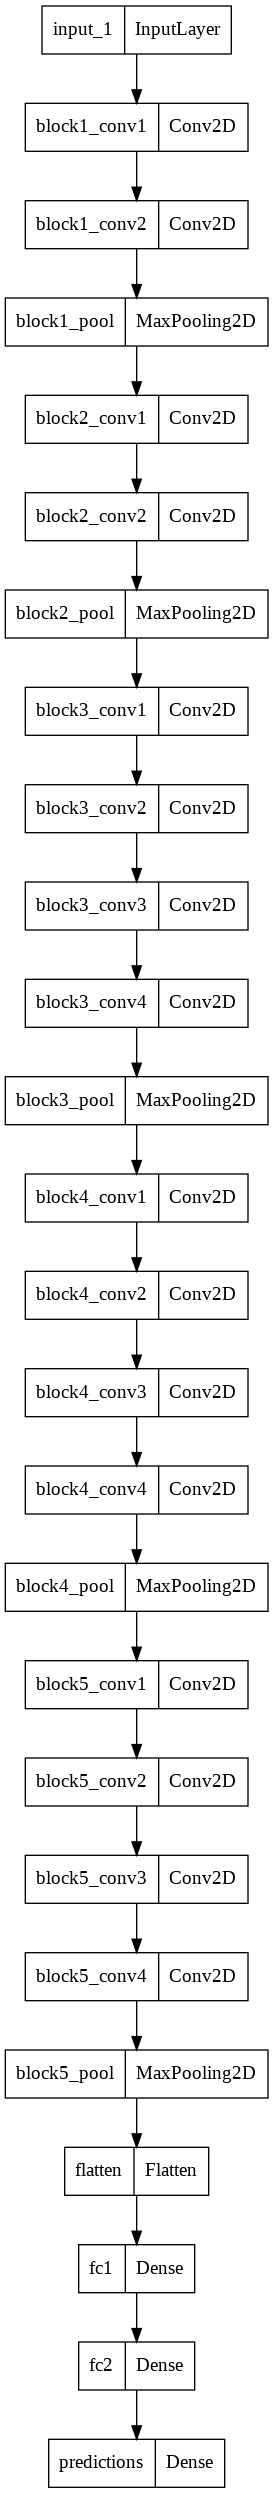

In [3]:
tf.keras.utils.plot_model(
    tf.keras.applications.VGG19(include_top=True, weights='imagenet'))

In [4]:
for layer in tf.keras.applications.VGG19(include_top=False, weights='imagenet').layers:
    print(layer.name)

input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


# Define Model:

In [5]:
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

content_layers = ['block5_conv2']

In [6]:
def gram_matrix(input_tensor):
  channels = int(input_tensor.shape[-1])
  a = tf.reshape(input_tensor, [-1, channels])
  n = tf.shape(a)[0]
  gram = tf.matmul(a, a, transpose_a=True)
  return gram / tf.cast(n, tf.float32)

def vgg_layers(layer_names):

  vgg =  tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)

  return model

class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)

    outputs = self.vgg(preprocessed_input)

    style_outputs , content_outputs = (outputs[:self.num_style_layers], 
                                       outputs[self.num_style_layers:])
    
    style_outputs = [gram_matrix(style_output) for style_output in style_outputs]

    content_dict =  {content_name: value for content_name, value in 
                     zip(self.content_layers, content_outputs)}

    style_dict =  {style_name: value for style_name, value in 
                     zip(self.style_layers, style_outputs)}


    return {'content': content_dict, 'style': style_dict}

#Training and generation:


In [7]:
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

extractor = StyleContentModel(style_layers, content_layers)

style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

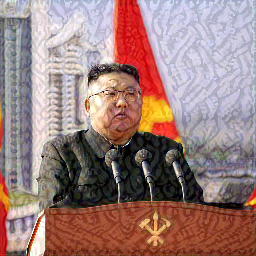

Train step: 10
.

In [ ]:
!rm stylized-image-*.png

def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)


style_weight=1e-2
content_weight=1e3

def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']

    style_loss = tf.add_n([tf.reduce_mean(tf.square((style_outputs[name]-style_targets[name]))) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean(tf.square((content_outputs[name]-content_targets[name]))) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers

    loss = style_loss + content_loss
    return loss

opt = tf.optimizers.Adam(learning_rate=0.01, beta_1=0.99, epsilon=1e-1)

total_variation_weight=50
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

image = tf.Variable(content_image)
#image = tf.Variable(np.random.rand(1,256,256,3))

epochs = 10
steps_per_epoch = 10
max_step = epochs * steps_per_epoch 
step_to_save = max_step*0.1

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
    if step%step_to_save ==0:
        print(f'STEP: {step} SAVING..')
        file_name = f'stylized-image-{step}.png'
        tensor_to_image(image).save(file_name)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

In [155]:
# @title Save and download generated image...  { display-mode: "form" }

print('SAVING AND DOWNLOADING GENERATED IMAGE...')
file_name = f'stylized-image-{step}.png'
tensor_to_image(image).save(file_name)

try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(file_name)

print('SAVING AND DOWNLOADING GENERATED IMAGE DONE')

SAVING AND DOWNLOADING GENERATED IMAGE...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

SAVING AND DOWNLOADING GENERATED IMAGE DONE


100%|██████████| 1/1 [00:00<00:00,  7.26it/s]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


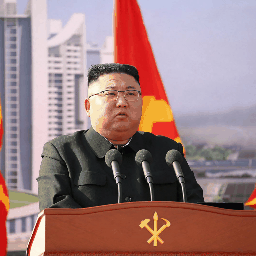

In [139]:
# @title Generate, save and download animated GIF... { display-mode: "form" }

anim_file = 'stylized-image.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('stylized-image-*.png')
  filenames = sorted(filenames)
  for filename in tqdm(filenames):
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)
  
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(anim_file)

embed.embed_file(anim_file)

# Fast Style

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

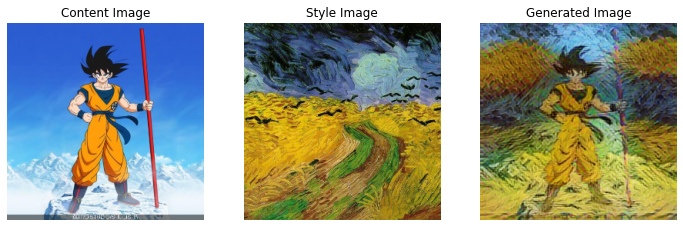

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [154]:
#https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2

hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
generated_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
#tensor_to_image(stylized_image)
tensor_to_image(content_image).save('content_image.jpg')
tensor_to_image(style_image).save('style_image.jpg')
tensor_to_image(generated_image).save('generated_image.jpg')


try:
  from google.colab import files
except ImportError:
   pass
else:
  for file_ in ['content_image.jpg', 'style_image.jpg', 'generated_image.jpg']:
    files.download(file_)

show_n([content_image, style_image, generated_image], titles=['Content Image', 'Style Image', 'Generated Image'])